In [1]:
import os
import glob as gb
import numpy as np 
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.applications import MobileNetV2,VGG16
from tensorflow.keras.layers import Conv2D,Flatten,Dropout,BatchNormalization,Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,array_to_img,img_to_array

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

**<p style="color:#6D4318">Preparing all data paths</p>**


In [2]:
fish_path=r'D:\Projects\Datasets\Fish_1\Fish_Dataset\Fish_Dataset'

**<p style="color:#6D4318">Find out the number of images in each folder</p>**

In [3]:
all_path=[] # To include the full path of each image
for img_path in os.listdir(fish_path): 
    if img_path in ['Segmentation_example_script.m','README.txt','license.txt'] :
        continue
        
    all_data=gb.glob(pathname=fish_path+'/'+img_path+'/'+img_path+'/*.*')
    print(' found {} in {} '.format(len(all_data),img_path))
    all_path.extend(all_data)#To add full path of each image in all_path list mentioned before

 found 1000 in Black Sea Sprat 
 found 1000 in Gilt-Head Bream 
 found 1000 in Hourse Mackerel 
 found 1000 in Red Mullet 
 found 1000 in Red Sea Bream 
 found 1000 in Sea Bass 
 found 1000 in Shrimp 
 found 1000 in Striped Red Mullet 
 found 1000 in Trout 


**<p style="color:#6D4318">Creat images data frame</p>**



In [4]:
images_df=pd.DataFrame({'Filepath':all_path})
images_df['Label']=images_df['Filepath'].apply(lambda x :x.split('/')[-2])
pd.options.display.max_colwidth = 200

#shuffling and reset index
images_df = images_df.sample(frac=1).reset_index(drop = True)
images_df.head(5)

Filepath  \
0  D:\Projects\Datasets\Fish_1\Fish_Dataset\Fish_Dataset/Striped Red Mullet/Striped Red Mullet\00581.png   
1                      D:\Projects\Datasets\Fish_1\Fish_Dataset\Fish_Dataset/Sea Bass/Sea Bass\00907.png   
2        D:\Projects\Datasets\Fish_1\Fish_Dataset\Fish_Dataset/Hourse Mackerel/Hourse Mackerel\00197.png   
3  D:\Projects\Datasets\Fish_1\Fish_Dataset\Fish_Dataset/Striped Red Mullet/Striped Red Mullet\00125.png   
4        D:\Projects\Datasets\Fish_1\Fish_Dataset\Fish_Dataset/Gilt-Head Bream/Gilt-Head Bream\00289.png   

                Label  
0  Striped Red Mullet  
1            Sea Bass  
2     Hourse Mackerel  
3  Striped Red Mullet  
4     Gilt-Head Bream

**<p style="color:#6D4318">Find out the distribution of each title in our data </p>**


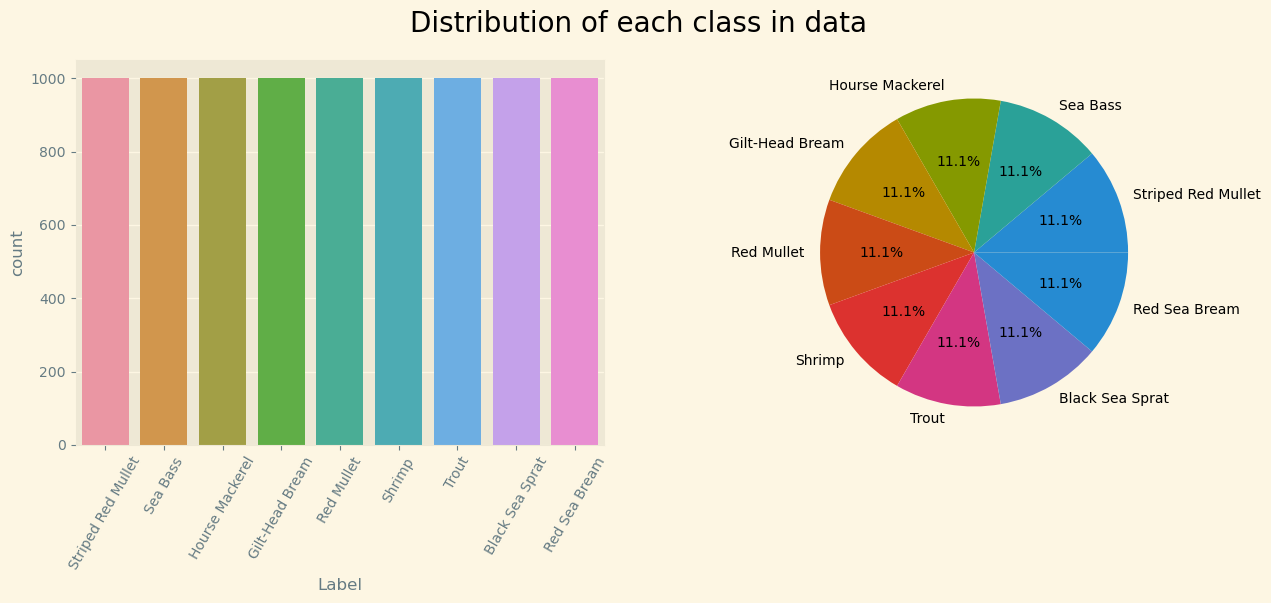

In [5]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=images_df,x='Label')
plt.xticks(rotation = 60)
plt.subplot(1,2,2)
plt.pie(x=images_df['Label'].value_counts().values,labels=images_df['Label'].value_counts().index,autopct='%1.1f%%')
plt.suptitle('Distribution of each class in data',size=20)
plt.show()

**<p style="color:#6D4318">Display 20 pictures of the dataset </p>**


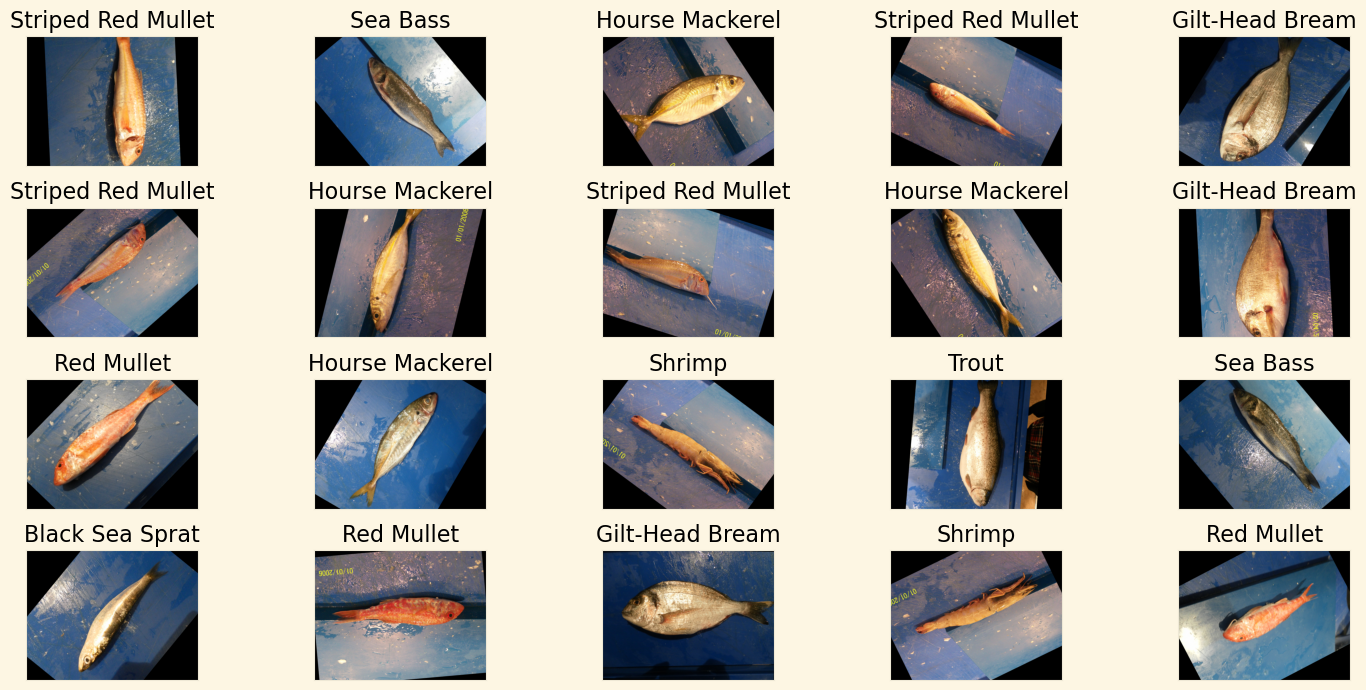

In [6]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(images_df.Filepath[i]))
    ax.set_title(images_df.Label[i])
plt.tight_layout()
plt.show()

**<p style="color:#6D4318">Data splitting </p>**


In [7]:
training_df,testing_df=train_test_split(images_df,test_size=0.1,shuffle=True,random_state=1)

print('The dimension of training data :',training_df.shape)
print('The dimension of testing data :',testing_df.shape)

The dimension of training data : (8100, 2)
The dimension of testing data : (900, 2)


**<p style="color:#6D4318">Data generators </p>**


In [8]:
training_generator=ImageDataGenerator(
                                     tf.keras.applications.vgg16.preprocess_input,
                                      validation_split=0.2,                                    
                                      )

testing_generator=ImageDataGenerator(
                                    tf.keras.applications.vgg16.preprocess_input
                                    )
                                    

In [9]:
training_images=training_generator.flow_from_dataframe(

    dataframe=training_df,
    x_col='Filepath',
    y_col='Label',
    class_mode='categorical',
    target_size=(224, 224),    
    color_mode='rgb',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
    
)


validation_images=training_generator.flow_from_dataframe(


    dataframe=training_df,
    x_col='Filepath',
    y_col='Label',
    class_mode='categorical',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'

)


testing_images=testing_generator.flow_from_dataframe(


    dataframe=testing_df,
    x_col='Filepath',
    y_col='Label',
    class_mode='categorical',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=32,
    shuffle=False,
)


Found 6480 validated image filenames belonging to 9 classes.
Found 1620 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


<center>
<img src="https://miro.medium.com/v2/resize:fit:827/1*UeAhoKM0kJfCPA03wt5H0A.png" alt="error" width="700" height="200"></center>

In [10]:
pretrained_model=VGG16(

    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable=False

In [11]:
early_stopping=EarlyStopping(monitor='val_loss',patience=3,verbose=1,restore_best_weights=True)

reduce_lr=ReduceLROnPlateau(monitor='val_loss',patience=2,verbose=0,factor=0.1)

model_check_point=ModelCheckpoint(monitor='val_accuracy',filepath='./bestmodel.h5',save_best_only=True,verbose=True)

**<p style="color:#6D4318">Training the model </p>**


In [12]:
epochs=7
batch_size=32


In [13]:
inputs=pretrained_model.input

x=Dense(128,activation='relu')(pretrained_model.output)
x=Dense(128,activation='relu')(x)
x=Dropout(rate=0.3)(x)
x=BatchNormalization()(x)
x=Dense(64,activation='relu')(x)

outputs=Dense(9,activation='softmax')(x)


model=Model(inputs=inputs, outputs=outputs)


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history=model.fit(
    
    training_images,
    validation_data=validation_images,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping,reduce_lr,model_check_point]

)

Epoch 1/7
203/203 [==============================] - ETA: 0s - loss: 0.7303 - accuracy: 0.7673
Epoch 1: val_accuracy improved from -inf to 0.98025, saving model to .\bestmodel.h5
203/203 [==============================] - 1457s 7s/step - loss: 0.7303 - accuracy: 0.7673 - val_loss: 0.0987 - val_accuracy: 0.9802 - lr: 0.0010
Epoch 2/7
203/203 [==============================] - ETA: 0s - loss: 0.1334 - accuracy: 0.9644
Epoch 2: val_accuracy improved from 0.98025 to 0.98889, saving model to .\bestmodel.h5
203/203 [==============================] - 1445s 7s/step - loss: 0.1334 - accuracy: 0.9644 - val_loss: 0.0422 - val_accuracy: 0.9889 - lr: 0.0010
Epoch 3/7
203/203 [==============================] - ETA: 0s - loss: 0.0576 - accuracy: 0.9830
Epoch 3: val_accuracy did not improve from 0.98889
203/203 [==============================] - 1621s 8s/step - loss: 0.0576 - accuracy: 0.9830 - val_loss: 0.1220 - val_accuracy: 0.9580 - lr: 0.0010
Epoch 4/7
203/203 [==============================] - ET

**<p style="color:#6D4318">Model summary</p>**


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

**<p style="color:#6D4318">plotting the model</p>**


In [15]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


**<p style="color:#6D4318">model history data frame</p>**


In [16]:
history_df=pd.DataFrame(history.history)
history_df

loss  accuracy  val_loss  val_accuracy      lr
0  0.730344  0.767284  0.098725      0.980247  0.0010
1  0.133436  0.964352  0.042155      0.988889  0.0010
2  0.057634  0.983025  0.122044      0.958025  0.0010
3  0.038853  0.986883  0.024881      0.992593  0.0010
4  0.027796  0.991512  0.031898      0.990123  0.0010
5  0.021760  0.992747  0.044966      0.982099  0.0010
6  0.017325  0.995062  0.005220      0.998148  0.0001

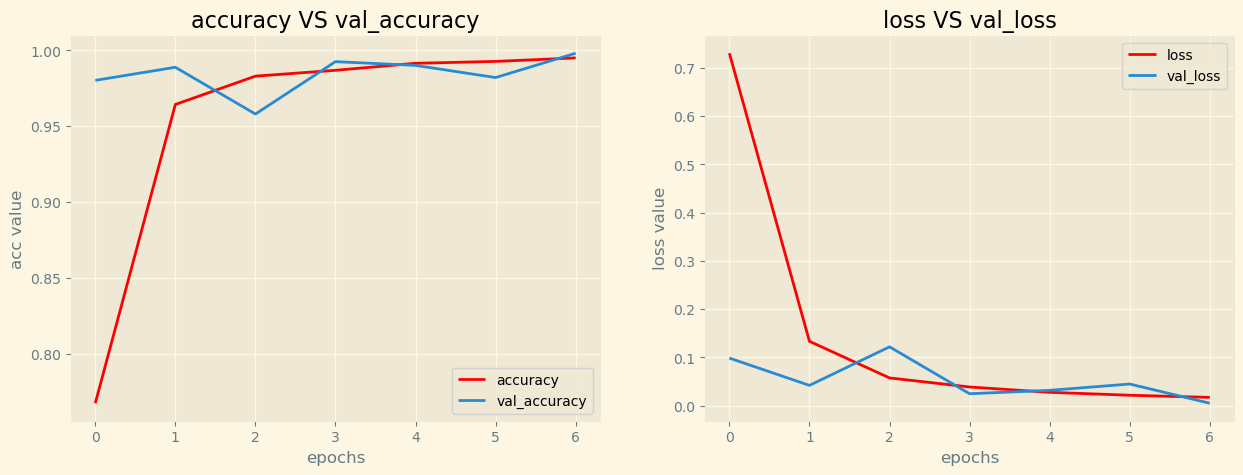

In [17]:
plt.figure(figsize=(15,5))

# plotting accuracy and val_accuracy
plt.subplot(1,2,1)
plt.plot(history_df['accuracy'],label='accuracy',c='red')
plt.plot(history_df['val_accuracy'],label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('acc value')
plt.title('accuracy VS val_accuracy')
plt.legend()
# plotting loss and val_loss
plt.subplot(1,2,2)
plt.plot(history_df['loss'],label='loss',c='red')
plt.plot(history_df['val_loss'],label='val_loss')
plt.title('loss VS val_loss')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.legend()

plt.show()

**<p style="color:#6D4318">Load the best validation accurecy model</p>**


In [18]:
from keras.models import load_model

model=load_model('D:\Projects\Fish Specie identification\Fish-Species-Identification/bestmodel.h5')

OSError: No file or directory found at /kaggle/working/bestmodel.h5

**<p style="color:#6D4318">Evaluate the model on test data</p>**


In [19]:
Evaluation=model.evaluate(testing_images)


print("Test Accuracy: {:.2f}%".format(Evaluation[1] * 100))
print("Test Loss: {:.5f}".format(Evaluation[0]))


29/29 [==============================] - 240s 8s/step - loss: 0.0111 - accuracy: 0.9978
Test Accuracy: 99.78%
Test Loss: 0.01106


**<p style="color:#6D4318">Model prediction</p>**


In [20]:
prediction=model.predict(testing_images)
prediction=np.argmax(prediction,axis=1)

29/29 [==============================] - 271s 9s/step


In [21]:
training_images.class_indices

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

In [24]:
labels = (training_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
prediction = [labels[k] for k in prediction]

KeyError: 'Striped Red Mullet'

In [25]:
y_true=testing_df['Label'].values
print(classification_report(y_true,prediction))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00        99
   Gilt-Head Bream       1.00      0.99      0.99        96
   Hourse Mackerel       0.99      1.00      0.99        92
        Red Mullet       1.00      1.00      1.00        93
     Red Sea Bream       0.99      1.00      1.00       101
          Sea Bass       1.00      1.00      1.00        99
            Shrimp       1.00      1.00      1.00       107
Striped Red Mullet       1.00      0.99      1.00       104
             Trout       1.00      1.00      1.00       109

          accuracy                           1.00       900
         macro avg       1.00      1.00      1.00       900
      weighted avg       1.00      1.00      1.00       900



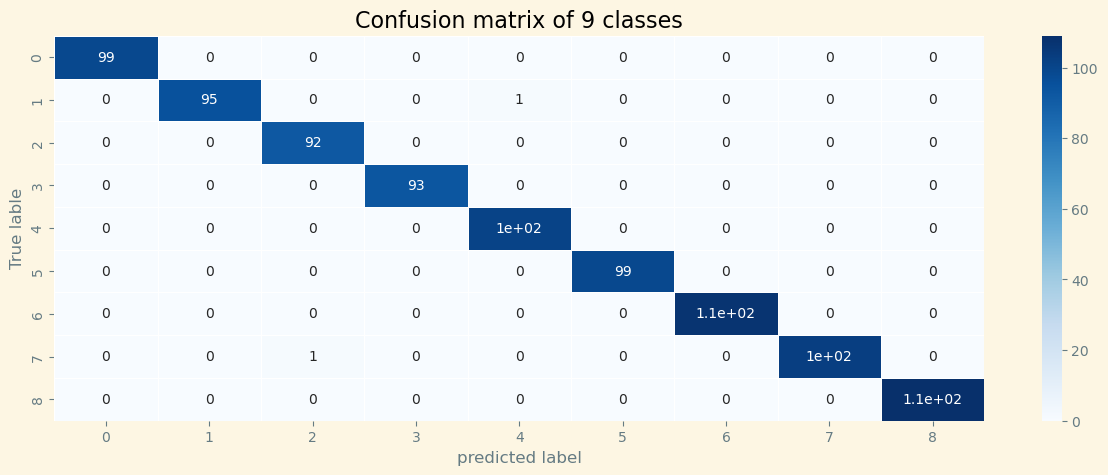

In [26]:
cm=confusion_matrix(y_true,prediction)
plt.figure(figsize=(15,5))
sns.heatmap(cm,annot=True,cmap='Blues',linewidths=0.5)
plt.xlabel('predicted label')
plt.ylabel('True lable')
plt.title('Confusion matrix of 9 classes')
plt.show()

**<p style="color:#6D4318">preparing dataframe for predicted values</p>**


In [27]:
temp_df=testing_df.copy()
temp_df['predicted']=prediction

temp_df.loc[temp_df['Label']==temp_df['predicted'],'Same'] = 'True'
temp_df.loc[temp_df['Label']!=temp_df['predicted'],'Same'] = 'False'
temp_df=temp_df.reset_index(drop=True)
temp_df.head()

Filepath  \
0  D:\Projects\Datasets\Fish_1\Fish_Dataset\Fish_Dataset/Striped Red Mullet/Striped Red Mullet\00496.png   
1                      D:\Projects\Datasets\Fish_1\Fish_Dataset\Fish_Dataset/Sea Bass/Sea Bass\00894.png   
2        D:\Projects\Datasets\Fish_1\Fish_Dataset\Fish_Dataset/Hourse Mackerel/Hourse Mackerel\00243.png   
3                  D:\Projects\Datasets\Fish_1\Fish_Dataset\Fish_Dataset/Red Mullet/Red Mullet\00519.png   
4                            D:\Projects\Datasets\Fish_1\Fish_Dataset\Fish_Dataset/Trout/Trout\00054.png   

                Label           predicted  Same  
0  Striped Red Mullet  Striped Red Mullet  True  
1            Sea Bass            Sea Bass  True  
2     Hourse Mackerel     Hourse Mackerel  True  
3          Red Mullet          Red Mullet  True  
4               Trout               Trout  True

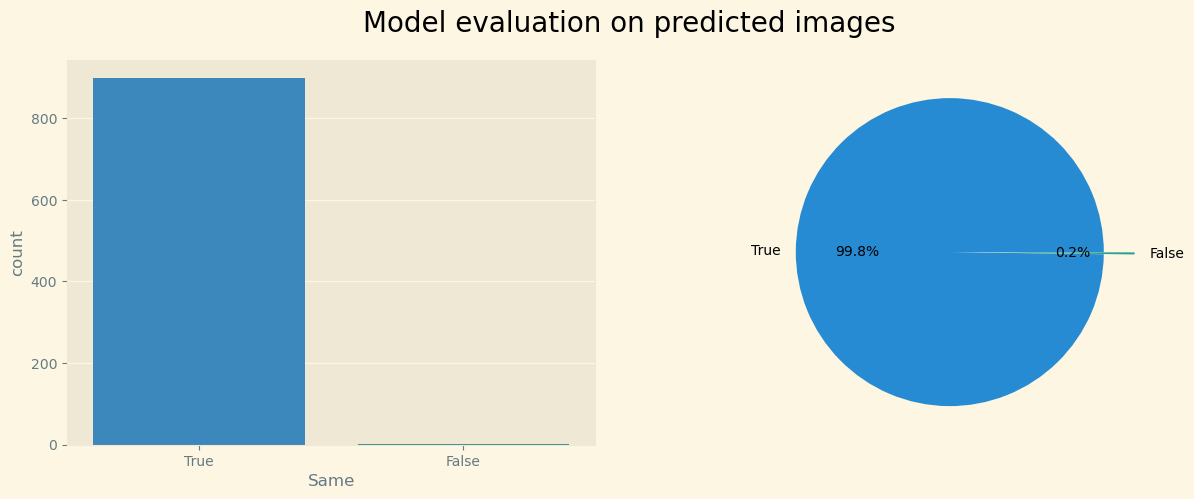

In [28]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.countplot(data=temp_df,x='Same')

plt.subplot(1,2,2)
plt.pie(x=temp_df['Same'].value_counts().values,labels=temp_df['Same'].value_counts().index,
        autopct='%1.1f%%',explode=[0.1,0.1])

plt.suptitle('Model evaluation on predicted images',size=20)
plt.show()

In [29]:
def display_image(temp_df):
    
    '''
    input : data frame 
    
    output : display 8 images from data frame with 
    '''
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(temp_df.Filepath.iloc[i]))
        ax.set_title(f"True: {temp_df.Label.iloc[i]}\nPredicted: {temp_df.predicted.iloc[i]}") 
    plt.tight_layout()
    plt.show()

**<p style="color:#6D4318">Displaying true predicted images</p>**


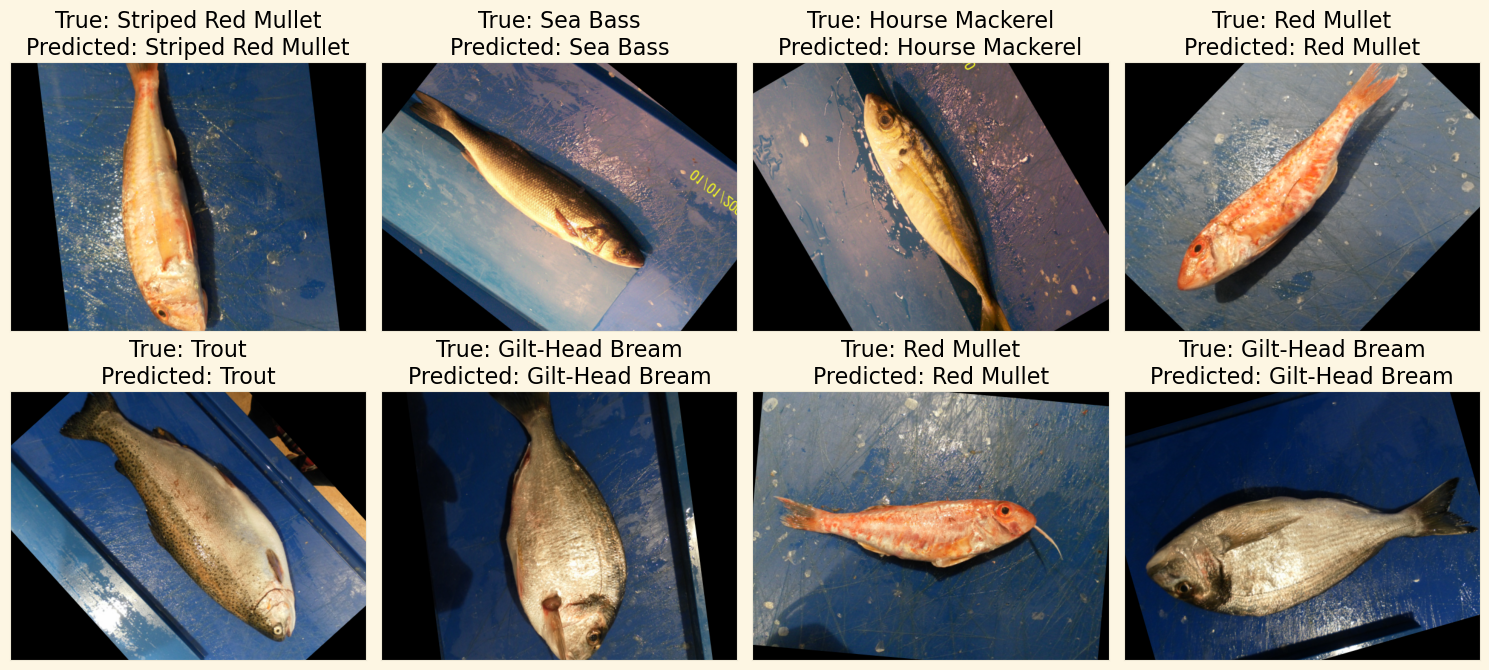

In [30]:
display_image(temp_df[temp_df['Same']=='True'])

**<p style="color:#6D4318">Displaying false predicted images</p>**


IndexError: single positional indexer is out-of-bounds

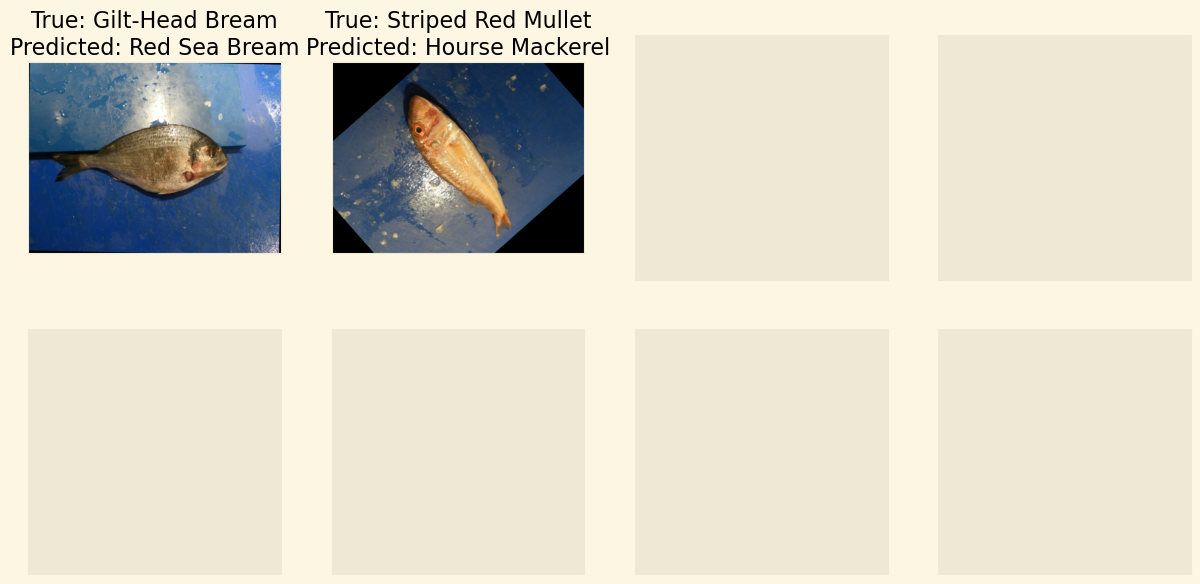

In [31]:
display_image(temp_df[temp_df['Same']=='False'])

In [ ]:
#last_conv_layer='block5_conv3'# You can know it through model summary

In [32]:
import matplotlib.cm as cm

def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    array = img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    
preprocess_input = tf.keras.applications.vgg16.preprocess_input
decode_predictions = tf.keras.applications.vgg16.decode_predictions

last_conv_layer_name = "block5_conv3"#from model summary
img_size = (224,224)

# Remove last layer's softmax
model.layers[-1].activation = None

In [33]:
def display_heatmap_image(df):
    
    '''
    input : data frame 
    
    output : display 8 grad-cam images from data frame with 
    '''
    
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        img_path = df.Filepath.iloc[i]
        img_array = preprocess_input(get_img_array(img_path, size=img_size))
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        cam_path = save_and_display_gradcam(img_path, heatmap)
        ax.imshow(plt.imread(cam_path))
        ax.set_title(f"True: {df.Label.iloc[i]}\nPredicted: {df.predicted.iloc[i]}")
    plt.tight_layout()
    plt.show()

**<p style="color:#6D4318">Displaying True predicted images heatmap</p>**


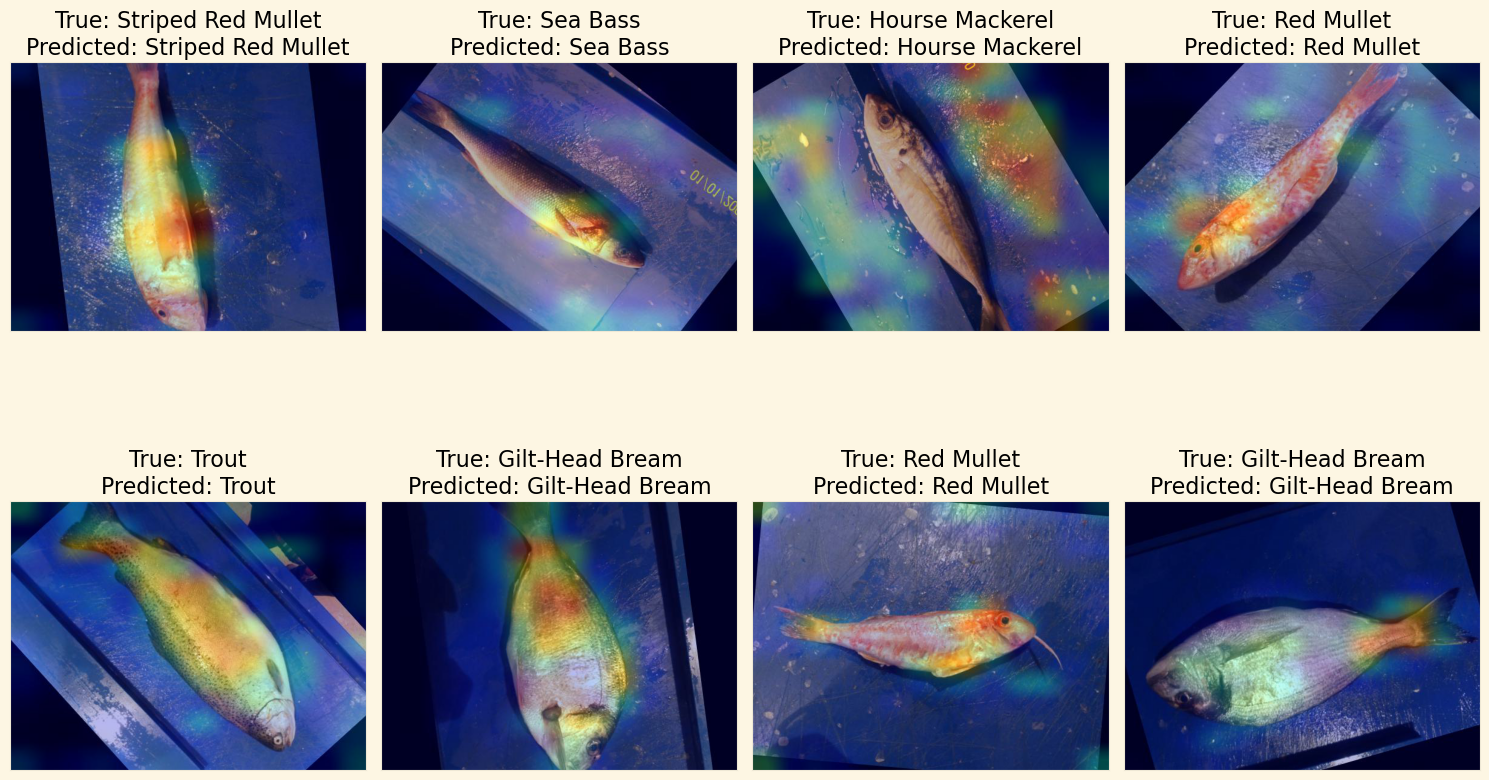

In [34]:
display_heatmap_image(temp_df[temp_df['Same']=='True'])

**<p style="color:#6D4318">Displaying false predicted images heatmap</p>**


IndexError: single positional indexer is out-of-bounds

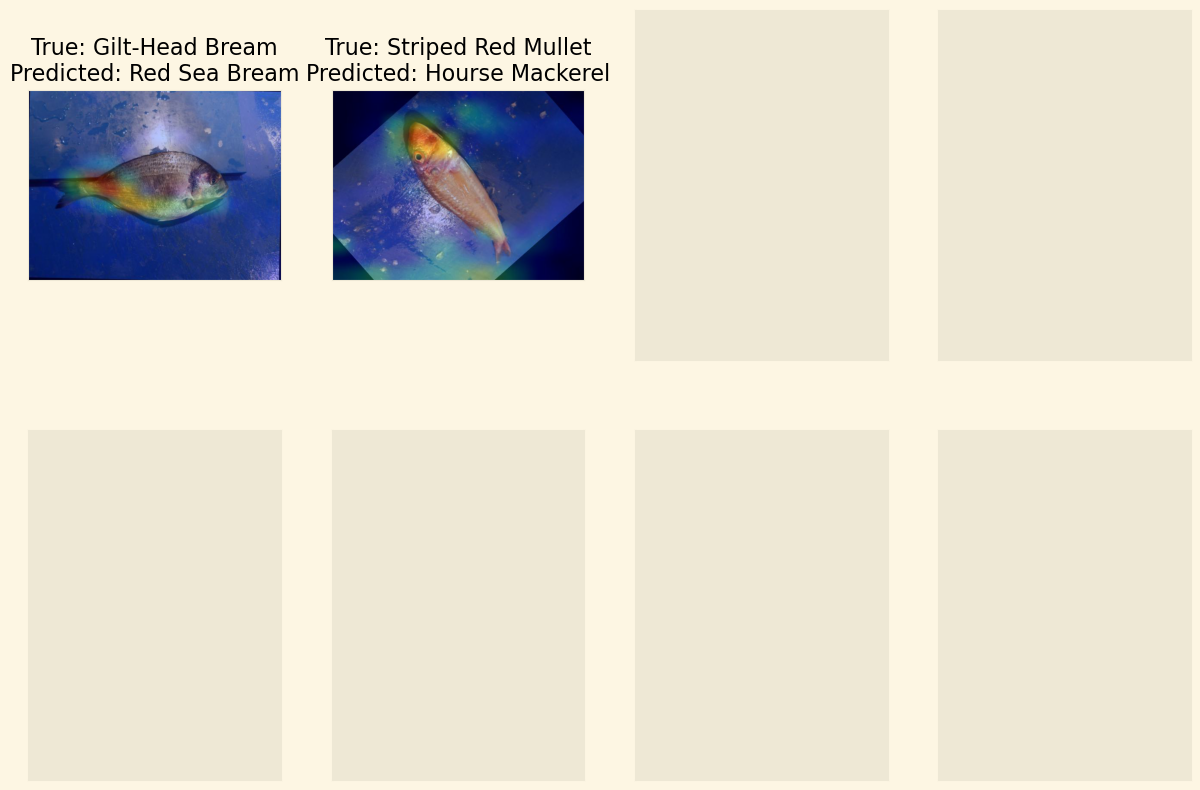

In [35]:
display_heatmap_image(temp_df[temp_df['Same']=='False'])